## Basic Data Preprocessing: from CSV files to Pytorch Datasets

In this part of the tutorial, we will prepare a Pytorch Dataset for a very simple classification problem, i.e., distinguishing between different types of Iris flowers.

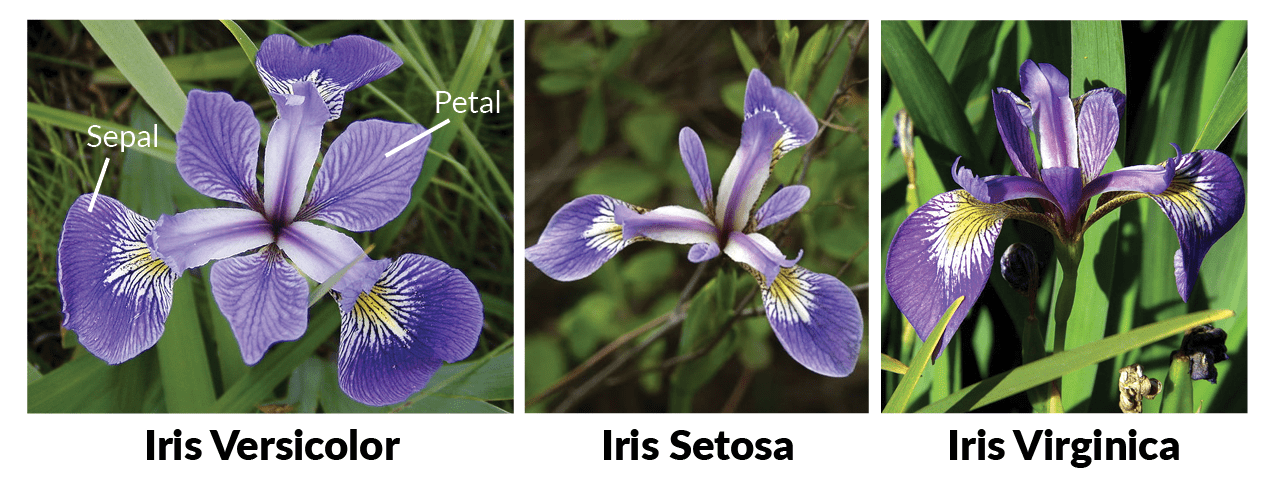

The dataset is stored as a CSV file in the `"data/iris_data.csv"` folder. In order to prepare a PyTorch Dataset, we will need to go through the following steps:
- Load the file with Pandas and perform some basic preprocessing
- Divide the data between training and test
- Create a Pytorch Dataset by extending the `torch.utils.data.Dataset` class

In [ ]:
import os
import pandas as pd

## Pandas

The best tool to preprocess your data in Python is Pandas.

You can use it to import data files such as CSV and XLSX, which are read as `DataFrame` objects. 

In order to read such data, you should specify either their absolute or relative path. I personally recommend to use relative paths, since they make the code easier to run on other people machine.

You can specify the path to a file simply as a string (e.g., `"data/iris_data.csv"`) or use the `os.path.join()` function. 

In [ ]:
datapath = os.path.join("data", "iris_data.csv")
print("Local path:", datapath)

Now, let's read the CSV file `"data/iris_data.csv"` with Pandas. We can do that using the `pd.read_csv()` function.

In [ ]:
df = pd.read_csv(datapath)

You can visualize the content of a Pandas `DataFrame` on your Jupyter notebook by typing the variable in an empty code cell.

In [ ]:
df

Individual columns of a `DataFrame` are called `Series` objects. Typically the operations that you can perform on DataFrames and Series are similar, but it is a good idea to always check the documentation.

In [ ]:
df['label']

You can see that the `label` column of the Iris dataset contains strings. However, in order to classify data with Pytorch, we need to encode the labels into integer values.

One simple way to do that is to create a dictionary mapping each string to an integer.

Let's start by seeing what are the possible labels for our data.
We can do that by using the `unique()` method of Pandas Series.

In [ ]:
print(df['label'].unique())

So there are 3 classes, meaning that we can define a simple dictionary in Python.
Dictionaries are simply containers that store key-value pairs.

For example, we can define the dictionary for the Iris labels as follows.

In [ ]:
label_dict = {
    'Iris-setosa': 0,
    'Iris-versicolor': 1,
    'Iris-virginica': 2
}
print(label_dict)

In [ ]:
print(label_dict['Iris-versicolor'])

However, this is how a kid would create a dictionary of labels. This method is not scalable, and prone to errors.
What if we have 100 classes? Or we accidentally misspell `Iris-versicolor` (what kind of name is that anyway?)?

The way a true data scientist would define his or her dictionary is this beautiful one-liner.

In [ ]:
label_dict = {label: i for i, label in enumerate(df['label'].unique())}
print(label_dict)

Now that we have defined our dictionary, we just need to apply it to ours labels.

We can do that by applying a lambda function to the `df['label']` Series.

In [ ]:
# Encoding categorial values (e.g., classes) as integers
df['label'] = df['label'].apply(lambda x: label_dict[x])


And since both `Series` and `DataFrame` objects are containers, the modifications affect the original `df` object.

In [ ]:
df

Now, we could save our updated DataFrame using the `to_csv()` method.

IMP: In most cases you want to set the parameter `index` to `False`. Otherwise, the CSV file will contain an extra column with the index values of the DataFrame. I have no idea why this parameter is set to `True` by default.

In [ ]:
datapath_new = os.path.join("data", "iris_new.csv")
df.to_csv(datapath_new, index=False)

## Train/test split

If you have any experience with machine learning, you known that you should not train and test on the same data.

For this reason, you should split your dataset into two sub-datasets: one will be used during training (<i>training data</i>) and the other for testing (<i>test data</i>).

First of all, let's convert our DataFrame to a Numpy array, and separate the input data from the ground-truth labels.

In [ ]:
all_data = df.to_numpy()
x_data = all_data[:, :-1]  # inputs
y_data = all_data[:, -1]  # ground truth

Now, time to actually split the dataset into training and test data.

We can do that by using the `train_test_split()` function of Scikit-Learn. You can find the documentation here: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

I have two main recommendations for you regarding this function:
- Make the split reproducible by setting a `random_state` (a typical value is 42)
- Use the `stratify` option w.r.t. the labels: this will ensure that the training and test data have roughly the same class distribution

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.33, random_state=42, stratify=y_data)


Let's print the shapes of our split data to check that everything has gone smoothly. 

In [ ]:
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

## Pickle

You probably noticed that preprocessing the data does not take much time (at least computation-wise).
So theoretically there's no problem doing that every time before running our code.
But what if we don't want to do that?

In Python, we can use the in-built Pickle module to save and load groups of variables in a compressed format.

IMP: Use Pickle only to save and load variables within your working space! The adopted format varies depeding on the version, so it is bad practice to use Pickle files to share data with others.

In [ ]:
import pickle

pickledatapath = os.path.join('data', 'iris_data.pkl')

with open(pickledatapath, 'wb') as f:
    pickle.dump([x_train, x_test, y_train, y_test], f)

## Pytorch Datasets and DataLoaders

In Pytorch, the best practice to feed data to your model is storing them as a Pytorch dataset and subsequently to divide them in batches with a DataLoader.

In order to define a Dataset in Pytorch, you need to extend the `Dataset` class and specify 3 methods:
- `__init__()`: the class constructor
- `__len__()`: a method that returns the dataset length
- `__getitem__`: the method used to subscript the dataset (i.e., that specifies what happens when you fetch an `index` in the dataset)

Let's create a Dataset class for Iris data.

In [ ]:
import torch
from torch.utils.data import Dataset

class MyIrisDataset(Dataset): # IMP: needs to extend Pytorch's Dataset class

    def __init__(self, x_data, y_data):
        super().__init__()
        assert len(x_data) == len(y_data) # check that inputs and labels have the same size
        self.x_data = torch.tensor(x_data, dtype=torch.float64)
        self.y_data = torch.tensor(y_data, dtype=torch.int64)

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

Now we can use the `MyIrisDataset` class to declare the train and test datasets.

In [ ]:
train_dataset = MyIrisDataset(x_train, y_train)
test_dataset = MyIrisDataset(x_test, y_test)

In [ ]:
print(train_dataset)

Pytorch Datasets can be fed to DataLoaders, which are essentially generators that divide the data into batches of fixed size.

In [ ]:
from torch.utils.data import DataLoader

# common practice: shuffle the training data
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

Let's see what one batch looks like.

In [ ]:
x_batch, y_batch = next(iter(train_loader))
    
print("x_batch shape:", x_batch.shape)
print("y_batch shape:", y_batch.shape)

If the number of data points is not a multiple of the batch size, the last batch will have size `len(data) % batch_size`.

In [ ]:
for x_batch, y_batch in train_loader:
    print('x_batch shape:', x_batch.shape)